In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import MLP
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import LinfDeepFoolAttack
from tqdm.notebook import tqdm
from attack_helper import batched_predictions, batched_logits, run_batched_attack_cpu, batched_logits_eps
from mlflow.tracking.artifact_utils import get_artifact_uri
import matplotlib.pyplot as plt

In [2]:
run_name = 1697314773
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = MLP(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])

test_rot = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.test_rot'].values[0])

if df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0] is None:
    flat = False
else:
    flat = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0])

if flat:
    padded_img_size = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.padded_img_size'].values[0])

    if test_rot:
        TEST_PATH = "flat_mnist_test_aug_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"
    else:
        TEST_PATH = "flat_mnist_test_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"

    test_data = load_train_data(TEST_PATH)

else:    
    if test_rot:
        TEST_PATH = "s2_mnist_cs1.gz"
        test_data = load_test_data(TEST_PATH)
    else:
        TEST_PATH = "s2_mnist_test_sphere_center.gz"
        test_data = load_train_data(TEST_PATH)

In [3]:
# total = 10000
total = 100
bs = 20

images = test_data[:total][0]
labels = test_data[:total][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

epsilons = [0, 0.5, 2.5, 5, 7.5, 10, 14, 20, 30]

In [4]:
clean_pred = batched_predictions(model, images, bs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
attack = LinfDeepFoolAttack(steps=50, overshoot=0.01, loss='crossentropy')
raw_advs, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons=epsilons, bs=bs)

success_rate = ep.astensor(success).float32().mean(axis=-1).raw
print(success_rate)

  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0.0000, 0.0800, 0.4900, 0.7100, 0.9200, 0.9700, 0.9900, 0.9900, 1.0000])


standard values for attack: <br>
 
$0.0000, 0.0800, 0.4900, 0.7100, 0.9100, 0.9700, 0.9900, 0.9900, 1.0000$ <br>

Choose: loss = overshoot=0.01, 'crossentropy'

In [6]:
t1 = time.time()
attack = LinfDeepFoolAttack(steps=50, overshoot=0.01, loss='crossentropy')
raw_advs, advs, success = attack(fmodel, images[:100].cuda(), clean_pred[:100].cuda(), epsilons=epsilons)
success_rate = ep.astensor(success).float32().mean(axis=-1).raw
print(success_rate)
t2 = time.time()
print(t2-t1)
attack = LinfDeepFoolAttack(steps=50, overshoot=0.01, loss='logits')
raw_advs, advs, success = attack(fmodel, images[:100].cuda(), clean_pred[:100].cuda(), epsilons=epsilons)
success_rate = ep.astensor(success).float32().mean(axis=-1).raw
print(success_rate)
t3 = time.time()
print(t3-t2)

tensor([0.0000, 0.0800, 0.4900, 0.7100, 0.9200, 0.9700, 0.9900, 0.9900, 1.0000],
       device='cuda:0')
1.2322819232940674
tensor([0.0000, 0.0800, 0.4900, 0.7100, 0.9200, 0.9700, 0.9900, 0.9900, 1.0000],
       device='cuda:0')
8.447223424911499


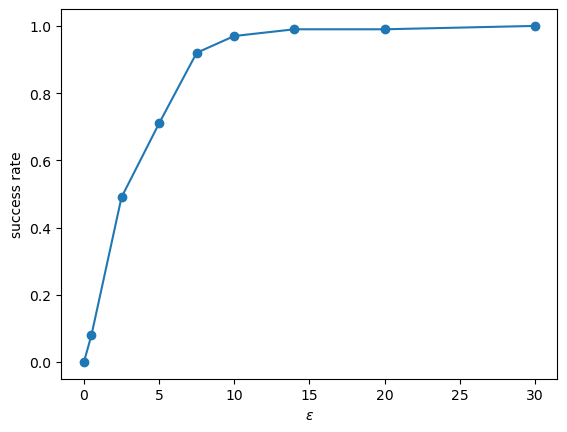

In [7]:
plt.plot(epsilons, success_rate.cpu(), 'o-')
plt.xlabel(r'$\epsilon$')
plt.ylabel('success rate')
plt.show()